In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('steam_games_limpio.csv', encoding='utf-8')
# Convertir la columna "release_date" al tipo datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
# Eliminamos una columna
df.drop('Unnamed: 0', axis=1,inplace=True)

In [4]:
# Paso 1: Reemplazar las palabras por 0 en la columna "price"
df['price'] = df['price'].apply(lambda x: '0' if isinstance(x, str) and not x.replace('.', '').isdigit() else x)

# Paso 2: Convertir la columna "price" al tipo decimal
df['price'] = df['price'].astype(float)

eliminar = ['app_name', 'title', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs', 'id', 'developer', 'sentiment', 'metascore', 'publisher','publisher']
df2 = df.drop(eliminar, axis=1)
df2.dropna(inplace=True)
df2

,genres,price,early_access
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",4.99,False
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",0.00,False
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",0.00,False
3,"['Action', 'Adventure', 'Casual']",0.99,False
5,"['Action', 'Adventure', 'Simulation']",3.99,False
...,...,...,...
32050,"['Action', 'Adventure', 'Casual', 'Indie']",1.99,False
32051,"['Casual', 'Indie', 'Simulation', 'Strategy']",1.99,False
32052,"['Casual', 'Indie', 'Strategy']",4.99,False
32053,"['Indie', 'Racing', 'Simulation']",1.99,False


In [5]:
import ast

# Convertir las listas en columnas de Python (evaluación de literales)
df2['genres'] = df2['genres'].apply(ast.literal_eval)

# Utilizar explode para deshacer las listas
df2_exploded = df2.explode('genres')

# Crear columnas dummy con get_dummies
df_dummies = pd.get_dummies(df2_exploded['genres'])

# Agregar la columna 'price' y 'ACCESO_ANTISIPADO' al DataFrame df_dummies
df_dummies['price'] = df2_exploded['price']
df_dummies['early_access'] = df2_exploded['early_access']

# Agrupar por el índice (género) y sumar las filas agrupadas
df_grouped = df_dummies.groupby(df_dummies.index).sum()

# Agregar las columnas 'price' y 'early_access' después del groupby
df_grouped['price'] = df2_exploded.groupby(df2_exploded.index).first()['price']
df_grouped['early_access'] = df2_exploded.groupby(df2_exploded.index).first()['early_access']

# Reemplazar df2 con el DataFrame final df_grouped
df2 = df_grouped

In [6]:
df2 = df2[df2['price'] != 0.00]
df2 = df2[df2['Free to Play'] != 1]
df2 = df2.drop('Free to Play', axis=1)
df2

,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,Early Access,Education,Indie,...,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing,price,early_access
0,0,1,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,4.99,False
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.99,False
5,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,3.99,False
12,0,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,10.99,False
13,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,3.99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32050,0,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1.99,False
32051,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,1.99,False
32052,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,4.99,False
32053,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,1.99,False


In [7]:
df2.columns

Index(['Accounting', 'Action', 'Adventure', 'Animation &amp; Modeling',
       'Audio Production', 'Casual', 'Design &amp; Illustration',
       'Early Access', 'Education', 'Indie', 'Massively Multiplayer',
       'Photo Editing', 'RPG', 'Racing', 'Simulation', 'Software Training',
       'Sports', 'Strategy', 'Utilities', 'Video Production', 'Web Publishing',
       'price', 'early_access'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [9]:

# Definir las columnas que serán características en el modelo (asegurándote de que todas sean numéricas)
X = df2.drop(columns=['price', 'Early Access'], axis=1)

y = df2['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Especificar el grado del polinomio deseado
grado_polinomio = 1

# Crea el transformador polinomial
poly = PolynomialFeatures(degree=grado_polinomio)

# Transforma las características de entrenamiento y prueba
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Crea el modelo de regresión lineal
modelo_regresion = LinearRegression()

# Entrena el modelo utilizando las características polinomiales
modelo_regresion.fit(X_train_poly, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = modelo_regresion.predict(X_test_poly)

# Calcular el Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular el Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mostrar el RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 13.986997522594669


In [10]:
import pickle
# Guardar el modelo, X_test_poly, y_test y y_pred en un archivo pkl
data_to_save = {'modelo': modelo_regresion, 'X_test_poly': X_test_poly, 'y_test': y_test, 'y_pred': y_pred, 'poly': poly, 'X': X}

with open('modelo.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

In [11]:
df2_filtrado = df2[(df2['Adventure'] != 0) & (df2['Action'] != 0) & (df2['Indie'] != 0) & (df2['Racing'] != 0)]
df2_filtrado['price'].mean()

5.80671052631579

In [13]:
import joblib
def predecir_precio_y_rmse(generos, early_access):
    # Cargar el modelo y los datos desde el archivo pkl
    data = joblib.load('modelo.pkl')
    modelo_regresion = data['modelo']
    poly = data['poly']
    X_test_poly = data['X_test_poly']
    y_test = data['y_test']

    # Crear un DataFrame con las características de los géneros a predecir
    generos_a_predecir_df = pd.DataFrame({genero: [1 if genero in generos else 0] for genero in X.columns})

    # Agregar la columna 'early_access' al DataFrame con el valor proporcionado por el usuario
    generos_a_predecir_df['early_access'] = int(early_access)

    # Transformar las características de los géneros a predecir utilizando el mismo transformador polinomial
    generos_a_predecir_poly = poly.transform(generos_a_predecir_df)

    # Realizar la predicción utilizando el modelo cargado
    precio_predicho = modelo_regresion.predict(generos_a_predecir_poly)[0]

    # Calcular el Mean Squared Error (MSE)
    y_pred = modelo_regresion.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)

    # Calcular el Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    return precio_predicho, rmse

# Ejemplo de uso:
generos_a_predecir = ['Adventure','Action', 'Indie', 'Racing']
early_access = True
precio_predicho, rmse = predecir_precio_y_rmse(generos_a_predecir, early_access)
print(f"Precio predicho: {round(precio_predicho, 2)}")
print(f"RMSE: {rmse}")

Precio predicho: 8.3
RMSE: 13.986997522594669


In [14]:
df2_exp = df2[df2['early_access'] != 0]
df2_exp['price'].mean()

10.8635233570863

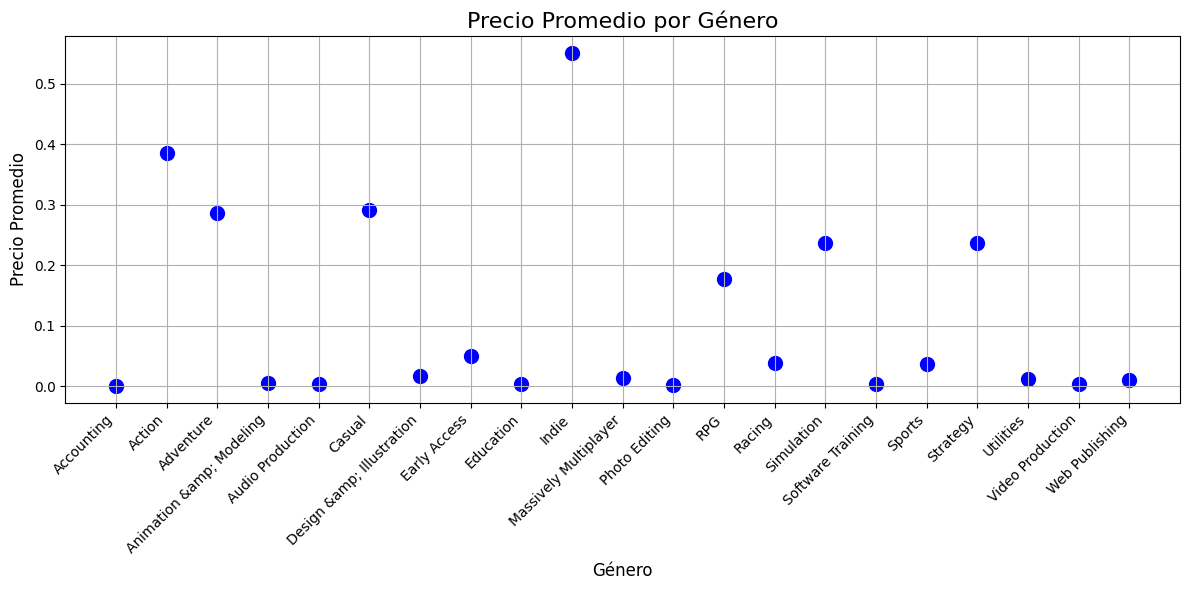